In [21]:
# Changed dense to 128

In [2]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

<b>1. Transfer Learning for Image Classification
It is highly recommended that you complete this project using Keras1 and Python.<br>
(a) In this problem, we are trying to build a classifier that distinguishes images of
nine types of waste.<br>
(b) Data Exploration and Pre-processing<br>
i. Images are numbered in each folder. Select the first 80% of the images in
each folder as your training set and the rest as the test set. You can encode
your classes using one-hot encoding.<br>
ii. In case all the images do not have the same size, zero-pad or resize the images
in your dataset. This can be done using various tools, including OpenCV.</b>

In [3]:
model_results = {}

In [4]:
# --- Configuration ---
DATASET_PATH = "../data/RealWaste/" 
IMG_SIZE = (299, 299)
SEED = 42

random.seed(SEED)
class_names = sorted(os.listdir(DATASET_PATH))
num_classes = len(class_names)

X_train, y_train = [], []
X_test, y_test = [], []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = sorted(os.listdir(class_dir))
    total = len(images)
    train_count = int(0.8 * total)
    
    train_files = images[:train_count]
    test_files = images[train_count:]

    def load_images(file_list):
        data = []
        for file in file_list:
            path = os.path.join(class_dir, file)
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                data.append(img)
        return data

    X_train.extend(load_images(train_files))
    y_train.extend([class_idx] * len(train_files))

    X_test.extend(load_images(test_files))
    y_test.extend([class_idx] * len(test_files))

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(" Done!")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

 Done!
X_train: (3798, 299, 299, 3) y_train: (3798, 9)
X_test: (954, 299, 299, 3) y_test: (954, 9)


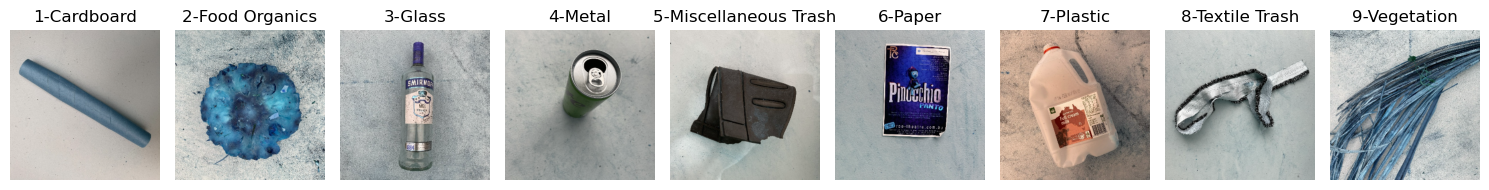

In [5]:
y_labels = np.argmax(y_train, axis=1)

plt.figure(figsize=(15, 5))

shown = set()
for idx in range(len(X_train)):
    class_idx = y_labels[idx]
    if class_idx not in shown:
        plt.subplot(1, num_classes, len(shown)+1)
        plt.imshow(X_train[idx].astype("uint8"))
        plt.title(class_names[class_idx])
        plt.axis('off')
        shown.add(class_idx)
    if len(shown) == num_classes:
        break

plt.tight_layout()
plt.show()

In [6]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
    RandomTranslation(0.1, 0.1)
], name="data_augmentation")

In [7]:
def initialise_transfer_model(model_name, input_shape=(224, 224, 3), num_classes=9):
    model_name = model_name.lower()

    match model_name:
        case "resnet50":
            base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        case "resnet101":
            base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
        case "vgg16":
            base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        case "efficientnetb0":
            base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        case _:
            raise ValueError(f"Unknown model: {model_name}")

    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)             # <--- augmentation happens here
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [8]:
def evaluate_metrics(y_true, y_pred):
    y_true_cls = np.argmax(y_true, axis=1)
    y_pred_cls = np.argmax(y_pred, axis=1)
    precision = precision_score(y_true_cls, y_pred_cls, average='macro')
    recall = recall_score(y_true_cls, y_pred_cls, average='macro')
    f1 = f1_score(y_true_cls, y_pred_cls, average='macro')
    try:
        auc = roc_auc_score(y_true, y_pred, multi_class='ovo', average='macro')
    except:
        auc = None
    return precision, recall, f1, auc

In [9]:
class early_Stop_After_Min_Runs(tf.keras.callbacks.EarlyStopping):
    def __init__(self, min_epochs=50, **kwargs):
        super().__init__(**kwargs)
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 >= self.min_epochs:
            super().on_epoch_end(epoch, logs)


def run_transfer_learning_pipeline(base_model_fn, X_train, y_train, X_val, y_val, X_test, y_test, batch_size=5, epochs=100):
    model = initialise_transfer_model(base_model_fn, input_shape=X_train.shape[1:], num_classes=y_train.shape[1])
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    # early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    early_stop = early_Stop_After_Min_Runs(monitor='val_loss', patience=3, restore_best_weights=True, min_epochs=50)
    initial_learning_rate = 3e-4  # or whatever you prefer

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',    # what to watch
        factor=0.5,            # reduce by 50%
        patience=3,            # wait 3 epochs with no improvement
        #min_lr=1e-4,           # don’t go below this
        verbose=1              # log when it happens
    )
    

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop,lr_scheduler],
                        verbose=1)


    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title("Loss Over Epochs")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(history.history['accuracy'], label='Train Acc')
    axes[1].plot(history.history['val_accuracy'], label='Val Acc')
    axes[1].set_title("Accuracy Over Epochs")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

    # Evaluate
    sets = ['Train', 'Validation', 'Test']
    trues = [y_train, y_val, y_test]
    preds = [y_pred_train, y_pred_val, y_pred_test]

    print("Set        | Precision | Recall | F1 Score | AUC")
    print("-----------|-----------|--------|----------|------")
    for name, y_t, y_p in zip(sets, trues, preds):
        precision, recall, f1, auc = evaluate_metrics(y_t, y_p)
        print(f"{name:<10} | {precision:.3f}     | {recall:.3f}  | {f1:.3f}    | {auc:.3f}")
        model_results[base_model_fn] = {
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1 Score": round(f1, 3),
            "AUC": round(auc, 3) if auc is not None else None
        }


=== Running: RESNET50 ===
Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.5574 - loss: 1.5670 - val_accuracy: 0.7708 - val_loss: 1.0673 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.8075 - loss: 0.9529 - val_accuracy: 0.7602 - val_loss: 1.0916 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.8359 - loss: 0.9028 - val_accuracy: 0.7931 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.8533 - loss: 0.8608 - val_accuracy: 0.7892 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.8857 - loss: 0.8089 - val_accuracy: 0.8235 - val_loss: 0.9638 - learning_rate: 0.0010
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.9147 - loss: 0.7471 - val_accuracy: 0.8050 - val_loss: 1.0068 - learning_rate: 0.0010
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 33

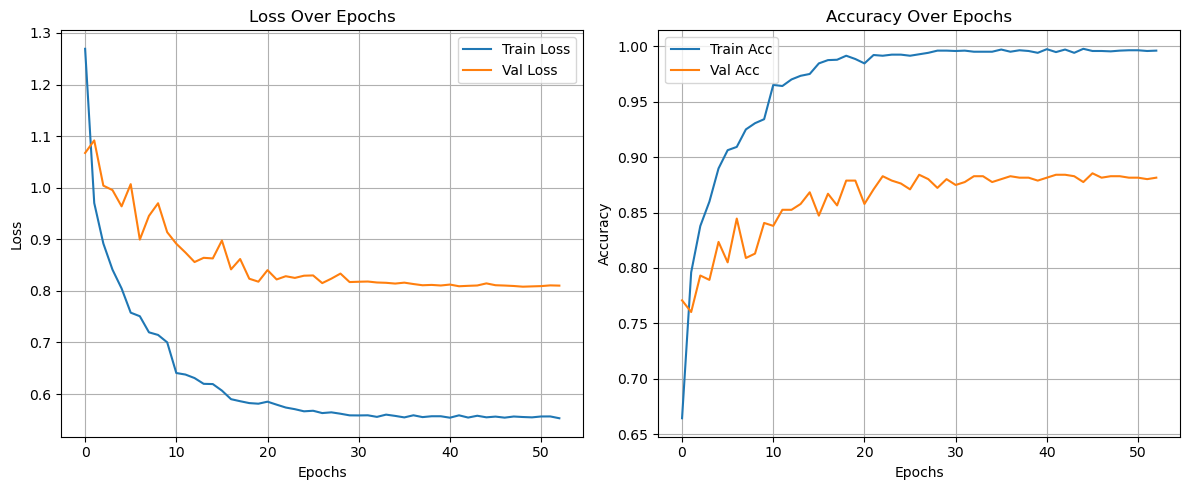

Set        | Precision | Recall | F1 Score | AUC
-----------|-----------|--------|----------|------
Train      | 0.989     | 0.989  | 0.989    | 1.000
Validation | 0.890     | 0.892  | 0.888    | 0.990
Test       | 0.835     | 0.808  | 0.813    | 0.980


In [10]:
print("\n=== Running: RESNET50 ===")
indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]
val_size = int(0.2 * len(X_train_shuffled))
X_val = X_train_shuffled[:val_size]
y_val = y_train_shuffled[:val_size]
X_train_split = X_train_shuffled[val_size:]
y_train_split = y_train_shuffled[val_size:]
run_transfer_learning_pipeline("resnet50", X_train_split, y_train_split, X_val, y_val, X_test, y_test)



Training RESNET101 model

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step - accuracy: 0.5794 - loss: 1.5104 - val_accuracy: 0.7457 - val_loss: 1.0844 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 49s 81ms/step - accuracy: 0.8002 - loss: 0.9691 - val_accuracy: 0.8103 - val_loss: 0.9625 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.8428 - loss: 0.8887 - val_accuracy: 0.7708 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - accuracy: 0.8613 - loss: 0.8496 - val_accuracy: 0.8142 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.8866 - loss: 0.8050 - val_accuracy: 0.8300 - val_loss: 0.9458 - learning_rate: 0.0010
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step - accuracy: 0.8913 - loss: 0.7974 - val_accuracy: 0.8024 - val_loss: 0.9687 - learning_rate: 0.0010
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 49

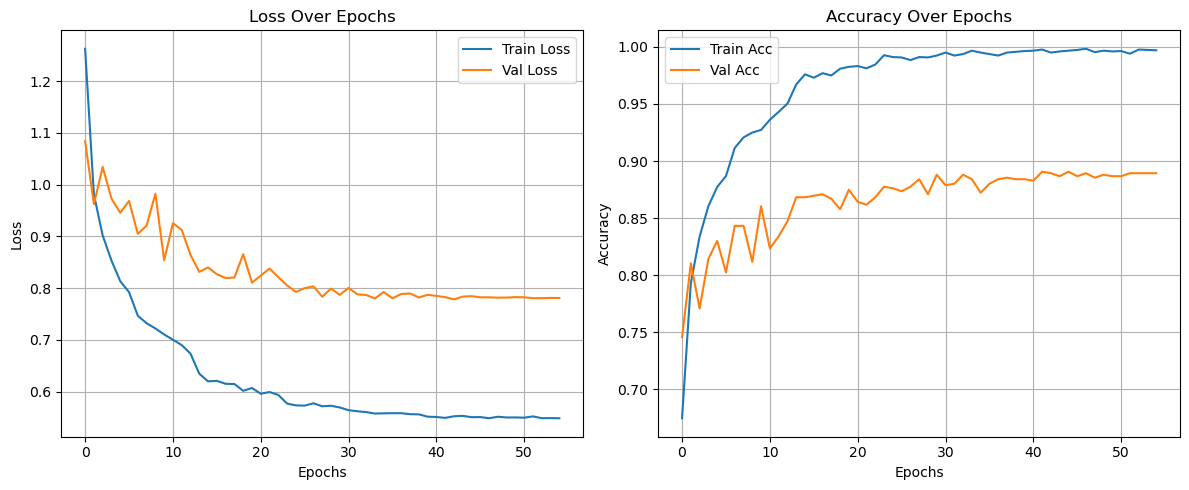

Set        | Precision | Recall | F1 Score | AUC
-----------|-----------|--------|----------|------
Train      | 0.996     | 0.995  | 0.996    | 1.000
Validation | 0.899     | 0.895  | 0.895    | 0.991
Test       | 0.868     | 0.843  | 0.851    | 0.978




In [18]:
print("\nTraining RESNET101 model\n")
indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]
val_size = int(0.2 * len(X_train_shuffled))
X_val = X_train_shuffled[:val_size]
y_val = y_train_shuffled[:val_size]
X_train_split = X_train_shuffled[val_size:]
y_train_split = y_train_shuffled[val_size:]
run_transfer_learning_pipeline("resnet101", X_train_split, y_train_split, X_val, y_val, X_test, y_test)
print("\n")


Training VGG16 Mode

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.4617 - loss: 2.1907 - val_accuracy: 0.7009 - val_loss: 1.2161 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.6740 - loss: 1.2330 - val_accuracy: 0.7510 - val_loss: 1.1072 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.7461 - loss: 1.1029 - val_accuracy: 0.7655 - val_loss: 1.1124 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.7824 - loss: 1.0268 - val_accuracy: 0.7734 - val_loss: 1.1058 - learning_rate: 0.0010
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.7873 - loss: 0.9987 - val_accuracy: 0.7773 - val_loss: 1.1046 - learning_rate: 0.0010
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.8222 - loss: 0.9444 - val_accuracy: 0.7971 - val_loss: 1.0540 - learning_rate: 0.0010
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 46s 76m

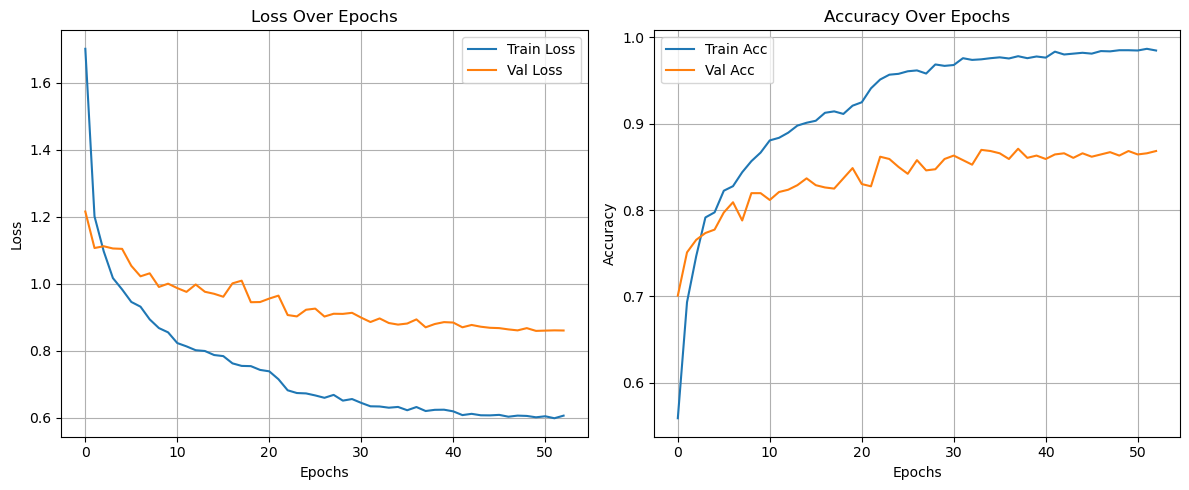

Set        | Precision | Recall | F1 Score | AUC
-----------|-----------|--------|----------|------
Train      | 0.997     | 0.997  | 0.997    | 1.000
Validation | 0.881     | 0.868  | 0.872    | 0.985
Test       | 0.791     | 0.768  | 0.774    | 0.969




In [16]:
print("\nTraining VGG16 Mode\n")
indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]
val_size = int(0.2 * len(X_train_shuffled))
X_val = X_train_shuffled[:val_size]
y_val = y_train_shuffled[:val_size]
X_train_split = X_train_shuffled[val_size:]
y_train_split = y_train_shuffled[val_size:]
run_transfer_learning_pipeline("vgg16", X_train_split, y_train_split, X_val, y_val, X_test, y_test)
print("\n")



Training EFFICIENTNETB0 model

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.5932 - loss: 1.3568 - val_accuracy: 0.8261 - val_loss: 0.9397 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8328 - loss: 0.9065 - val_accuracy: 0.8287 - val_loss: 0.9262 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8666 - loss: 0.8154 - val_accuracy: 0.8472 - val_loss: 0.8865 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9010 - loss: 0.7612 - val_accuracy: 0.8577 - val_loss: 0.8610 - learning_rate: 0.0010
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9114 - loss: 0.7274 - val_accuracy: 0.8735 - val_loss: 0.8474 - learning_rate: 0.0010
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9194 - loss: 0.7142 - val_accuracy: 0.8814 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━

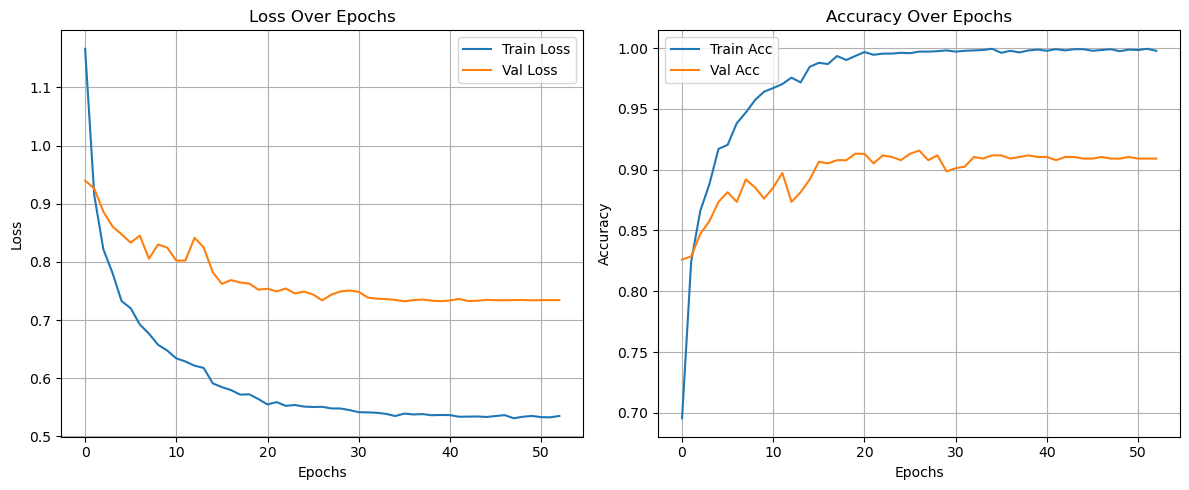

Set        | Precision | Recall | F1 Score | AUC
-----------|-----------|--------|----------|------
Train      | 0.999     | 1.000  | 0.999    | 1.000
Validation | 0.916     | 0.916  | 0.915    | 0.993
Test       | 0.853     | 0.840  | 0.842    | 0.984




In [19]:
print("\nTraining EFFICIENTNETB0 model\n")
indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]
val_size = int(0.2 * len(X_train_shuffled))
X_val = X_train_shuffled[:val_size]
y_val = y_train_shuffled[:val_size]
X_train_split = X_train_shuffled[val_size:]
y_train_split = y_train_shuffled[val_size:]
run_transfer_learning_pipeline("efficientnetb0", X_train_split, y_train_split, X_val, y_val, X_test, y_test)
print("\n")

In [20]:
df = pd.DataFrame.from_dict(model_results, orient='index')
df.index.name = 'Model'
df

,Precision,Recall,F1 Score,AUC
Model,,,,
resnet50,0.835,0.808,0.813,0.980
vgg16,0.791,0.768,0.774,0.969
resnet101,0.868,0.843,0.851,0.978
efficientnetb0,0.853,0.840,0.842,0.984
